# Yawar Mahmood : TMA4180 : Project : Code

# Import Necessary Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import approx_fprime
from mpl_toolkits.mplot3d import Axes3D
import time

We start by defining overall functions used that are used in the rest of the project. These functions are:
- Line search
- BFGS
- Plotting function for Cable Nets and Tensegrity Domes
- Plotting function for Free Standing structures

# Line Search

In [2]:
# Function to perform line search to determine the optimal step size. 
# This implementation uses the Armijo condition along with curvature conditions to ensure Wolfe Conditions. 

def lineSearch(search_direction, current_point, objective_function, gradient_function, rho=3, c1=0.1, c2=1):
    max_step_size = 1 # Initial maximum step size
    min_step_size = 0.1 # Initial minimum step size
    max_iterations_for_extrapolation = 100 # Limit on the number of extrapolation iterations
    max_iterations_for_interpolation = 100 # Limit on the number of interpolation iterations
    
    # Calculate initial gradient dot product, used in coming conditions
    initial_descent = np.dot(gradient_function(current_point), search_direction)
    
    # Get objective function value at the current point
    current_function_value = objective_function(current_point)

    # Define the Armijo condition function for sufficient decrease
    def armijo_condition(step_size):
        # Evaluate the objective function to see if the reduced function value satisfies the Armijo condition
        return objective_function(current_point + step_size * search_direction) <= current_function_value + c1 * step_size * initial_descent

    # Define curvature condition functions to check the curvature
    def curvature_condition_low(step_size):
        # Low curvature condition, to ensure the slope has reduced sufficiently
        return c2 * initial_descent <= np.dot(gradient_function(current_point + step_size * search_direction), search_direction)

    def curvature_condition_high(step_size):
        # High curvature condition, to ensure the slope has not reduced too much
        return -c2 * initial_descent >= np.dot(gradient_function(current_point + step_size * search_direction), search_direction)

    # Extrapolation phase to increase step size until conditions fail
    for _ in range(max_iterations_for_extrapolation):
        if not armijo_condition(max_step_size) or not curvature_condition_low(max_step_size):
            break
        min_step_size = max_step_size
        max_step_size = rho * max_step_size # Increase step size
    
    # Bisection interpolation phase to fine-tune step size
    step_size = (min_step_size + max_step_size) / 2
    for _ in range(max_iterations_for_interpolation):
        if armijo_condition(step_size) and curvature_condition_low(step_size) and curvature_condition_high(step_size):
            break # If all conditions are met, finalize the step size
        if armijo_condition(step_size) and not curvature_condition_low(step_size):
            min_step_size = step_size # Narrow down the interval from below
        else:
            max_step_size = step_size # Narrow down the interval from above
        step_size = (min_step_size + max_step_size) / 2 # Update step size to midpoint of the interval

    # Return the computed step size
    return step_size

# BFGS

In [3]:
# BFGS optimization function for finding the minimum of a given function.
# This BFGS uses Line Search to find optimal the "optimal" step size.

def bfgs(initial_guess, objective_function, gradient_function=None, max_iterations=100, gradient_approximation_epsilon=1e-14, convergence_tolerance=1e-6):
    # Approximate it using finite differences, if none are specified. 
    if gradient_function is None:
        gradient_function = lambda x: approx_fprime(x, objective_function, epsilon=gradient_approximation_epsilon)
    
    # Initialize variables for optimization
    current_position = initial_guess # Starting point
    energy_record = [objective_function(current_position)] # Record of function values at each iteration, so that energy of each configuration can be calculated
    inverse_hessian_approximation = np.identity(len(initial_guess)) # Initial approximation to the inverse Hessian as the identity matrix
    
    for iteration in range(max_iterations):
        current_gradient = gradient_function(current_position) # Gradient at the current position
        
        # Termination condition: stop if the gradient norm is less than the convergence tolerance
        #if np.linalg.norm(current_gradient) < convergence_tolerance:
        #    break
        
        # Compute search direction as the product of negative inverse Hessian and the gradient
        search_direction = -inverse_hessian_approximation @ current_gradient
        # Find the optimal step size using line search along the search direction
        step_size = lineSearch(search_direction, current_position, objective_function, gradient_function)
        next_position = current_position + step_size * search_direction # update position
        
        # Calculate changes in position and gradient
        position_change = next_position - current_position
        gradient_change = gradient_function(next_position) - current_gradient
        
        # Compute the curvature of the objective function along the search direction
        curvature = np.dot(gradient_change, position_change)
        #if curvature <= 0: # If curvature is non-positive, break out of the loop
        #    break
        
        # Update formula for the inverse Hessian approximation
        rho = 1 / curvature
        identity_matrix = np.eye(len(initial_guess)) # Identity matrix of appropriate size
        update_matrix = identity_matrix - rho * np.outer(position_change, gradient_change) # Rank one update matrix
        # Update the inverse Hessian approximation using the Sherman-Morrison formula
        inverse_hessian_approximation = update_matrix @ inverse_hessian_approximation @ update_matrix.T + rho * np.outer(position_change, position_change)
        
        # Update the current position to the new position
        current_position = next_position
        # Record the new objective function value
        energy_record.append(objective_function(current_position))
    
    # Return the final position and the record of energy values
    return current_position, energy_record

# Plot Function: Cable Nets and Tensegrity Domes

In [4]:
def plot_structures(fixed_nodes, initial_nodes, optimized_nodes, connections, recorded_energies):
    
    # Combining fixed and free nodes for initial and optimized plots
    initial_positions = np.vstack([fixed_nodes, initial_nodes])
    optimized_positions = np.vstack([fixed_nodes, optimized_nodes])

    # Setting up the figure
    fig = plt.figure(figsize=(18, 6))
    
    # Plot initial structure
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(initial_positions[:len(fixed_nodes), 0], initial_positions[:len(fixed_nodes), 1], initial_positions[:len(fixed_nodes), 2], c='red', marker='o', s=100, label='Fixed Nodes')
    ax1.scatter(initial_positions[len(fixed_nodes):, 0], initial_positions[len(fixed_nodes):, 1], initial_positions[len(fixed_nodes):, 2], c='green', marker='^', s=100, label='Initial Free Nodes')
    for connection_type in connections:
        for start, end in connections[connection_type]:
            start, end = int(start)-1, int(end)-1
            ax1.plot([initial_positions[start][0], initial_positions[end][0]],
                     [initial_positions[start][1], initial_positions[end][1]],
                     [initial_positions[start][2], initial_positions[end][2]], 'k-' if connection_type == 'cables' else 'gray', alpha=0.5)
    ax1.set_title('Initial Structure')
    ax1.set_xlabel('X Axis')
    ax1.set_ylabel('Y Axis')
    ax1.set_zlabel('Z Axis')
    ax1.legend()

    # Plot optimized structure
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(optimized_positions[:len(fixed_nodes), 0], optimized_positions[:len(fixed_nodes), 1], optimized_positions[:len(fixed_nodes), 2], c='red', marker='o', s=100, label='Fixed Nodes')
    ax2.scatter(optimized_positions[len(fixed_nodes):, 0], optimized_positions[len(fixed_nodes):, 1], optimized_positions[len(fixed_nodes):, 2], c='blue', marker='^', s=100, label='Optimized Free Nodes')
    for connection_type in connections:
        for start, end in connections[connection_type]:
            start, end = int(start)-1, int(end)-1
            ax2.plot([optimized_positions[start][0], optimized_positions[end][0]],
                     [optimized_positions[start][1], optimized_positions[end][1]],
                     [optimized_positions[start][2], optimized_positions[end][2]], 'k-' if connection_type == 'cables' else 'gray', alpha=0.5)
    ax2.set_title('Optimized Structure')
    ax2.set_xlabel('X Axis')
    ax2.set_ylabel('Y Axis')
    ax2.set_zlabel('Z Axis')
    ax2.legend()

    # Plot convergence
    ax3 = fig.add_subplot(133)
    ax3.plot(recorded_energies, label='Convergence')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Total Energy')
    ax3.set_title('Convergence Plot')
    ax3.legend()

    # Final adjustments
    plt.tight_layout()
    plt.show()

# Plotting Function: Free Standing 

In [5]:
def plot_optimization_results(initial_positions, optimized_positions, energies, edges):
    
    fig = plt.figure(figsize=(18, 6))

    # 3D plot for the initial positions
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(initial_positions[:, 0], initial_positions[:, 1], initial_positions[:, 2], c='red', marker='o', s=100, label='Initial Guess')
    for edge in edges:
        start, end = int(edge[0])-1, int(edge[1])-1
        ax1.plot([initial_positions[start][0], initial_positions[end][0]],
                 [initial_positions[start][1], initial_positions[end][1]],
                 [initial_positions[start][2], initial_positions[end][2]], 'gray', alpha=0.5)
    ax1.set_title('Initial Positions')
    ax1.set_xlabel('X Axis')
    ax1.set_ylabel('Y Axis')
    ax1.set_zlabel('Z Axis')
    ax1.legend()

    # 3D plot for the optimized positions
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(optimized_positions[:, 0], optimized_positions[:, 1], optimized_positions[:, 2], c='blue', marker='o', s=100, label='Optimized BFGS')
    for edge in edges:
        start, end = int(edge[0])-1, int(edge[1])-1
        ax2.plot([optimized_positions[start][0], optimized_positions[end][0]],
                 [optimized_positions[start][1], optimized_positions[end][1]],
                 [optimized_positions[start][2], optimized_positions[end][2]], 'k-', alpha=0.5)
    ax2.set_title('Optimized Structure')
    ax2.set_xlabel('X Axis')
    ax2.set_ylabel('Y Axis')
    ax2.set_zlabel('Z Axis')
    ax2.legend()

    # Convergence plot
    ax3 = fig.add_subplot(133)
    ax3.plot(energies, label='BFGS Energy Convergence')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Total Energy')
    ax3.set_title('Convergence Plot')
    ax3.legend()

    plt.tight_layout()
    plt.show()

Now that the "general" functions are defined and out of the way, we will be considering 3 optimization cases in this order:
- Cable Nets
- Tensegrity Domes
- Free Standing Structures

# Cable Nets

### Energy Functions

In [6]:
# Function to calculate elastic energy of a cable
def elastic_energy(positions, node_index_one, node_index_two):
    distance = np.linalg.norm(positions[node_index_one] - positions[node_index_two])
    if distance > resting_length_of_cables:
        return 0.5 * material_parameter * ((distance - resting_length_of_cables) ** 2) / (resting_length_of_cables ** 2)
    return 0

# Function to calculate total energy of the system
def total_energy(positions_array):
    positions_array = positions_array.reshape(-1, 3)
    combined_positions = np.vstack([fixed_node_positions, positions_array])
    
    total_energy = 0
    for node_one, node_two in edges:
        total_energy += elastic_energy(combined_positions, node_one, node_two)
    total_energy += np.sum(positions_array[:, 2]) * mass_gravity_effect
    return total_energy

### Problem Setup 

In [7]:
# Constants for material properties
material_parameter = 3
resting_length_of_cables = 3
mass_gravity_effect = 1/6

# Fixed positions of nodes in the structure
fixed_node_positions = np.array([
    [5, 5, 0],
    [-5, 5, 0],
    [-5, -5, 0],
    [5, -5, 0]
])

edges = [
    (0, 4), (1, 5),
    (2, 6), (3, 7),
    (4, 5), (5, 6), (6, 7), (7, 4)
]

# Cable connections between nodes, adjusted for one-based indexing, for the sake of plotting
cable_connections = {
    'cables': [('1', '5'), ('2', '6'), ('3', '7'), ('4', '8'), ('5', '6'), ('6', '7'), ('7', '8'), ('8', '5')]
}

# Initial guess for optimization
initial_free_node_positions = np.array([[0, 0, 10], [0, 0, 10], [0, 0, 10], [0, 0, 10]])

### Optimization and plotting

[[ 1.99999858  1.99999859 -1.50000069]
 [-2.00000181  1.99999831 -1.50000116]
 [-2.00000153 -2.00000154 -1.50000164]
 [ 1.9999983  -2.00000181 -1.50000116]]


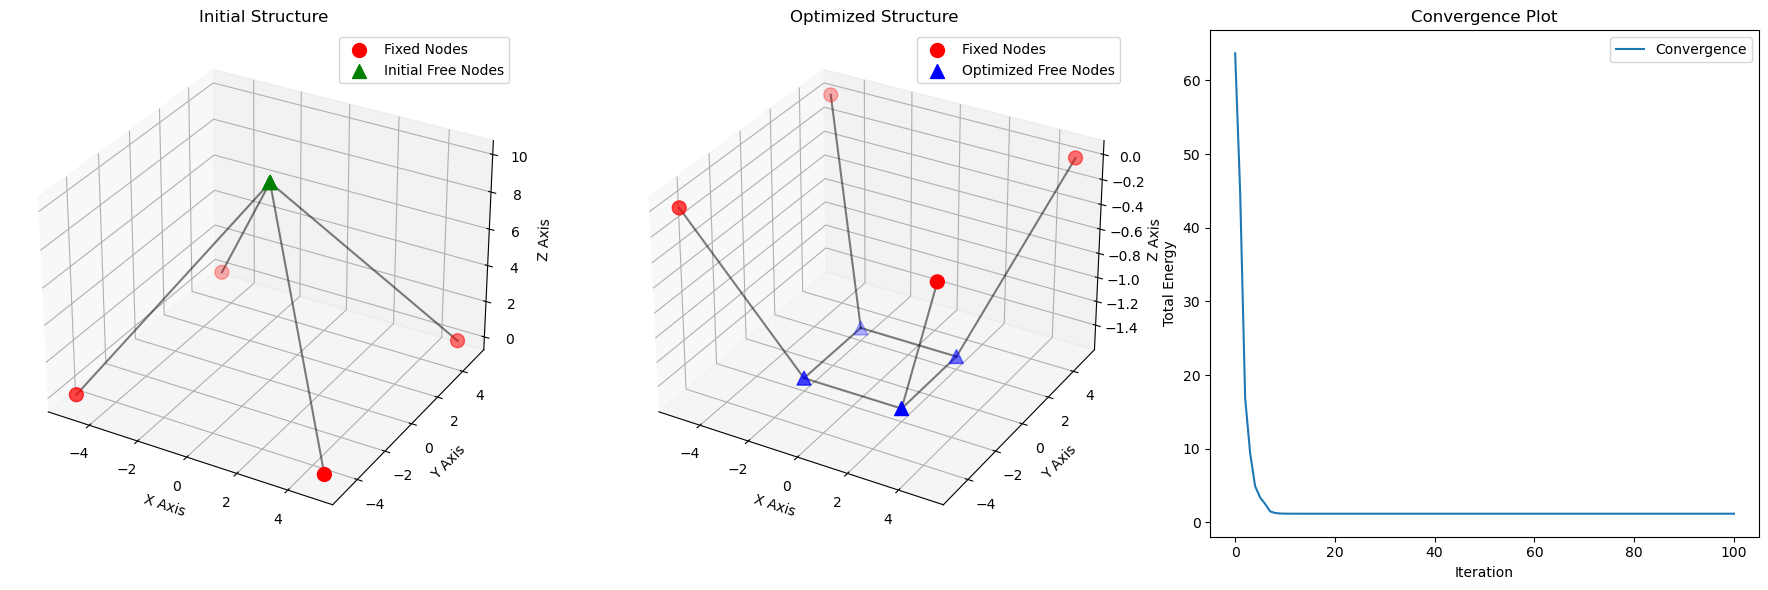

In [8]:
optimized_positions_flat, recorded_energies = bfgs(initial_free_node_positions.flatten(), total_energy, lambda x: approx_fprime(x, total_energy, epsilon=1e-6))
optimized_positions = optimized_positions_flat.reshape(-1, 3)

print(optimized_positions)

# Call the plotting function
plot_structures(fixed_node_positions, initial_free_node_positions, optimized_positions, cable_connections, recorded_energies)

# Tensegrity Domes

### Energy Functions

In [9]:
# Helper function to calculate Euclidean distance between two points
def distance(point1, point2):
    return np.linalg.norm(point1 - point2)

# Function to compute the elastic energy of a bar between two points
def elastic_energy_bar(positions, node1_index, node2_index, resting_length):
    distance_between_nodes = distance(positions[node1_index], positions[node2_index])
    return stiffness_bar / 2 * ((distance_between_nodes - resting_length) ** 2) / resting_length ** 2

# Function to compute the elastic energy of a cable between two points
def elastic_energy_cable(positions, node1_index, node2_index, resting_length):
    distance_between_nodes = distance(positions[node1_index], positions[node2_index])
    if distance_between_nodes > resting_length:
        return stiffness_cable / 2 * ((distance_between_nodes - resting_length) ** 2) / resting_length ** 2
    return 0

# Function to compute the total energy of the structure
def total_energy(configuration):
    configuration = configuration.reshape(-1, 3)
    combined_node_positions = np.vstack([fixed_node_positions, configuration])
    total_system_energy = 0
    for bar in bars_connections:
        node1, node2 = int(bar[0])-1, int(bar[1])-1
        total_system_energy += elastic_energy_bar(combined_node_positions, node1, node2, resting_length_bars[bar[0]+bar[1]])
    for cable in cables_connections:
        node1, node2 = int(cable[0])-1, int(cable[1])-1
        total_system_energy += elastic_energy_cable(combined_node_positions, node1, node2, resting_length_cables[cable[0]+cable[1]])
    return total_system_energy

### Problem Setup

In [10]:
stiffness_bar = 1 # Stiffness constant for bars
stiffness_cable = 0.1 # Stiffness constant for cables
fixed_node_positions = np.array([(1, 1, 0), (-1, 1, 0), (-1, -1, 0), (1, -1, 0)])
bars_connections = [('1', '5'), ('2', '6'), ('3', '7'), ('4', '8')]
cables_connections = [('5', '6'), ('6', '7'), ('7', '8'), ('5', '8'), ('1', '8'), ('2', '5'), ('3', '6'), ('4', '7')]
resting_length_bars = {'15': 10, '26': 10, '37': 10, '48': 10}
resting_length_cables = {'18': 8, '25': 8, '36': 8, '47': 8, '56': 1, '67': 1, '78': 1, '58': 1}

# Prepare the connections dictionary for the plotting function
connections = {
    'bars': bars_connections,
    'cables': cables_connections
}

### Optimization and plotting, starting point 1

[[-7.10603302e-01 -1.01777286e-03  9.54260955e+00]
 [-7.75270922e-04 -7.10599619e-01  9.54281975e+00]
 [ 7.08806639e-01 -7.79023247e-04  9.54312689e+00]
 [-1.01355622e-03  7.08810271e-01  9.54291675e+00]]


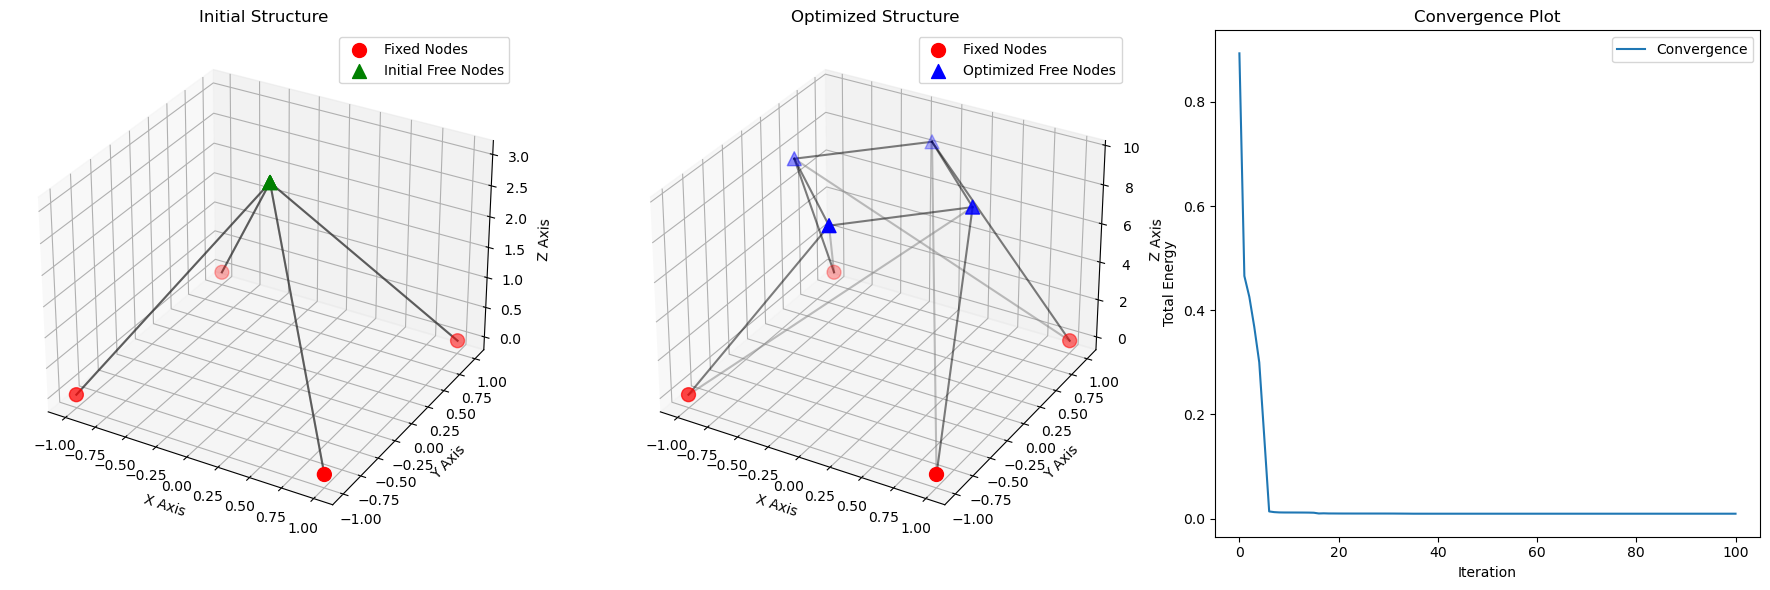

In [11]:
# Initial guess and optimization
initial_free_node_guess = np.array([[0, 0, 3], [0, 0, 3], [0, 0, 3], [0, 0, 3]])

optimized_positions_flat, recorded_energies = bfgs(initial_free_node_guess.flatten(), total_energy, lambda config: approx_fprime(config, total_energy, epsilon=1e-6))
optimized_positions = optimized_positions_flat.reshape(-1, 3)

print(optimized_positions)

# Call the plot function
plot_structures(fixed_node_positions, initial_free_node_guess, optimized_positions, connections, recorded_energies)

### Optimization and plotting, starting point 2

[[-0.46793821 -0.16239906  9.55808749]
 [ 0.23617037 -0.87443543  9.4909855 ]
 [ 0.93807597 -0.15526491  9.52078762]
 [ 0.23347596  0.55749168  9.5838139 ]]


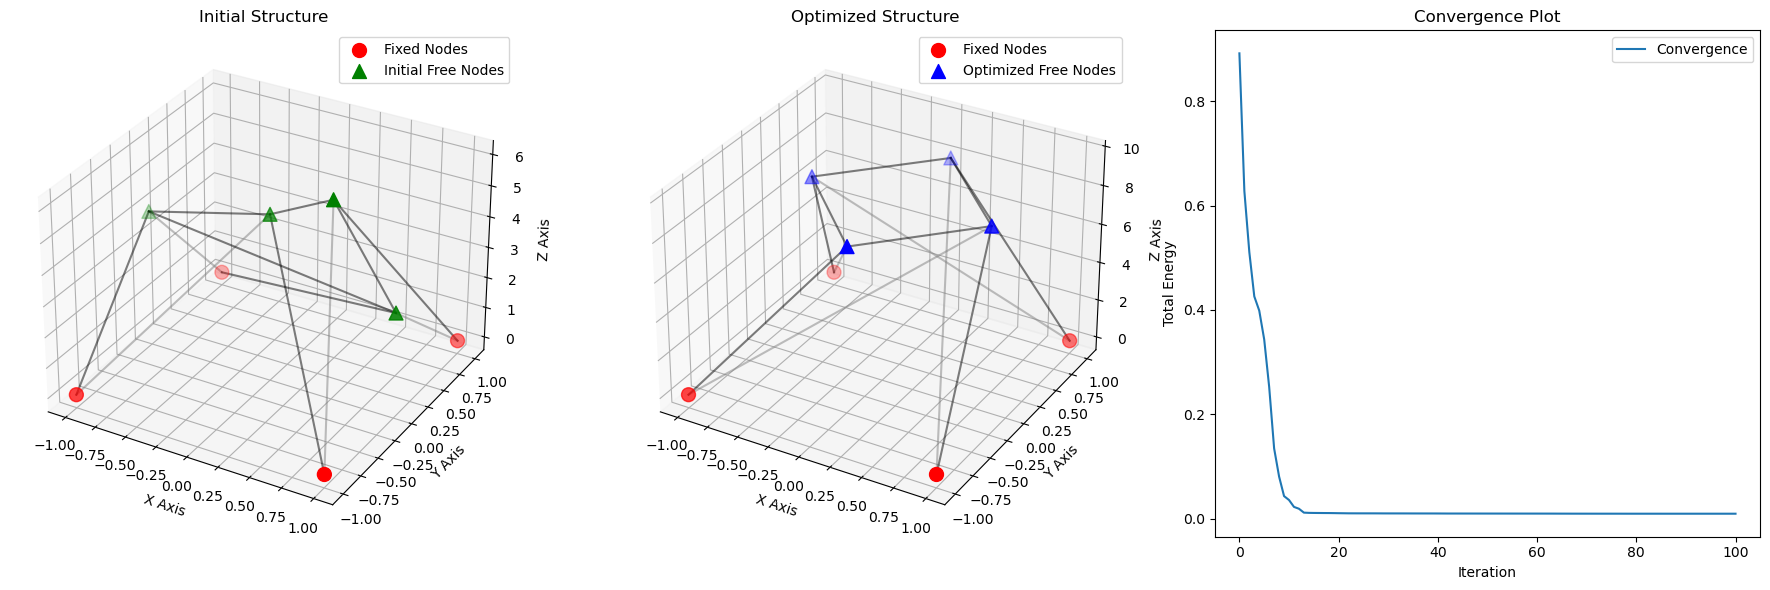

In [12]:
# Initial guess and optimization
initial_free_node_guess = np.array([[1, 0, 3], [-1, 0, 4], [0, 0, 5], [0.5, 0, 6]])

optimized_positions_flat, recorded_energies = bfgs(initial_free_node_guess.flatten(), total_energy, lambda config: approx_fprime(config, total_energy, epsilon=1e-6))
optimized_positions = optimized_positions_flat.reshape(-1, 3)

print(optimized_positions)

# Call the plot function
plot_structures(fixed_node_positions, initial_free_node_guess, optimized_positions, connections, recorded_energies)

# Free Standing

### Energy Functions

In [13]:
# Function to compute the total energy of the structure
def total_energy_with_penalty(X):
    X = X.reshape(-1, 3)
    energy = 0
    for edge in edges:
        i, j = int(edge[0])-1, int(edge[1])-1
        dist = np.linalg.norm(X[i] - X[j])
        l_ij = l_cable[edge]
        if '5' <= edge[0] <= '8' or '5' <= edge[1] <= '8':
            if dist > l_ij:
                energy += k / 2 * ((dist - l_ij) ** 2) / l_ij ** 2
        else:
            energy += c / 2 * ((dist - l_ij) ** 2) / l_ij ** 2 + g_rho * dist * (X[i][2] + X[j][2]) / 2
    # Apply penalty for nodes below the height profile
    for i in range(len(X)):
        height_violation = f(X[i, 0], X[i, 1]) - X[i, 2]
        if height_violation > 0:  # Node is below the ground
            energy += 0.1 * height_violation ** 2 # 0.1 = penalty scale
    return energy

### Height Profile

In [14]:
# Given in task description
def f(x1, x2):
    return (x1**2 + x2**2) / 20

### Problem Setup

In [15]:
# Constants for material properties
c = 1
k = 0.1
g_rho = 1e-11

l_cable = {
    '12': 2, '23': 2, '34': 2, '14': 2,
    '56': 1, '67': 1, '78': 1, '58': 1,
    '15': 10, '26': 10, '37': 10, '48': 10,
    '18': 8, '25': 8, '36': 8, '47': 8
}

edges = list(l_cable.keys())

initial_guess = np.array([
    [0.5, 0.5, 0], [-0.5, 0.5, 0], [-0.5, -0.5, 0], [0.5, -0.5, 0],
    [-0.4, 0.1, 10], [0.1,-0.4,10], [0.4,0.1,10], [0.1, 0.4, 10]
]).flatten()

### Optimization and Plotting

[[ 0.98084961  1.01089195  1.33725745]
 [-1.01829085  0.97292415  1.29258139]
 [-1.00121395 -1.02572054  1.22097293]
 [ 0.99711923 -0.98856673  1.2936651 ]
 [-0.47617943  0.1201142   9.12564626]
 [ 0.03792198 -0.43527831  9.13029191]
 [ 0.43508025 -0.01159332  9.15149385]
 [ 0.1858634   0.43424342  9.15417082]]


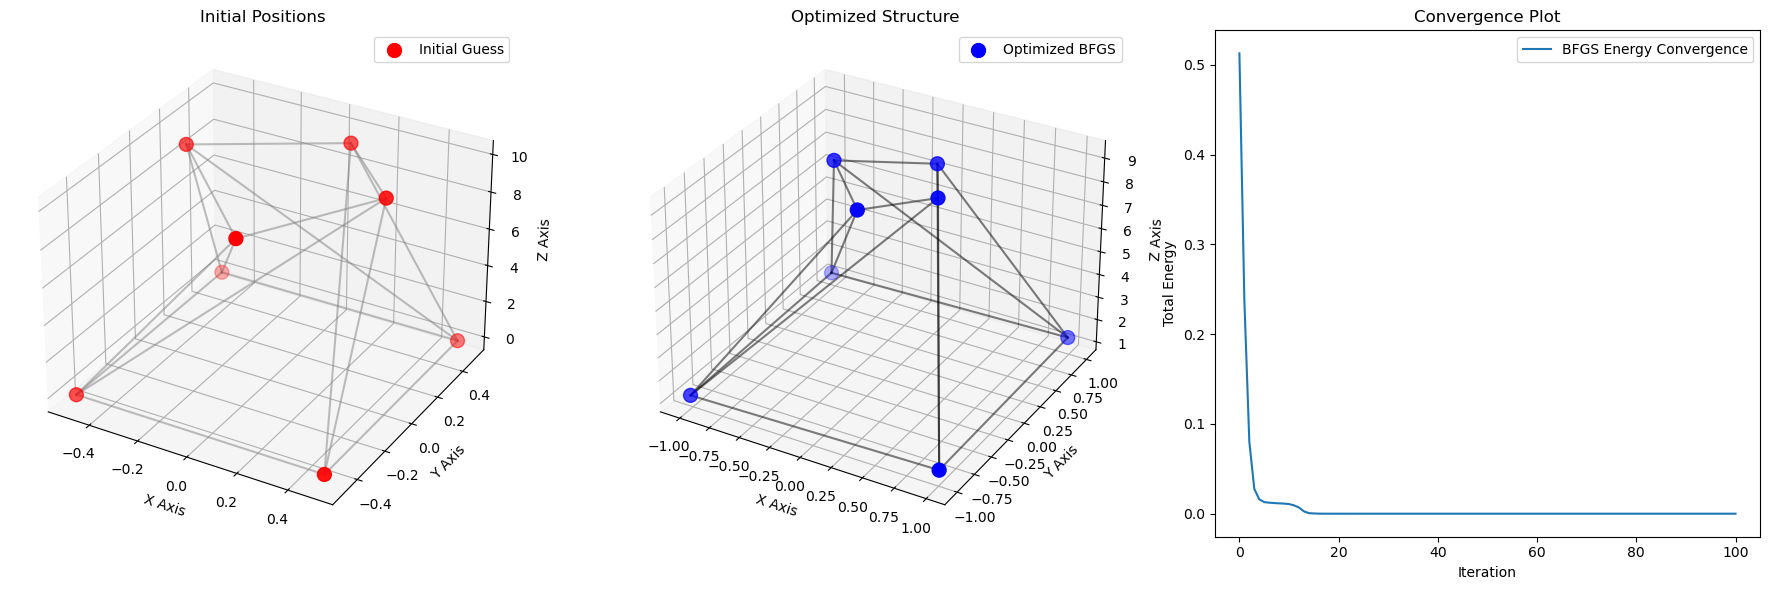

In [16]:
start_time_bfgs = time.time()
optimized_positions_flat, energies = bfgs(initial_guess, total_energy_with_penalty)  # Ensure bfgs function is defined
elapsed_time_bfgs = time.time() - start_time_bfgs

optimized_positions = optimized_positions_flat.reshape(-1, 3)
initial_positions = initial_guess.reshape(-1, 3)

print(optimized_positions)

# Call the plotting function
plot_optimization_results(initial_positions, optimized_positions, energies, edges)